# Analysis of Chess Ratings and Socio-Economic Factors

This project explores the relationship between chess player ratings and various socio-economic factors across different countries. By analyzing data on chess ratings, socio-economic indicators, happiness index we aim to uncover patterns and insights that highlight the impact of socio-economic environments on chess performance. The analysis includes clustering countries based on their socio-economic profiles, examining correlations between socio-economic factors and chess ratings, and comparing the production of titled players in different countries.

## Data Sources


1. **Fide Ratings** <br>
    Dataset: 'fide_2023.csv' <br>
    Contains player ratings in Standard, Rapid, and Blitz formats, along with player titles (GM, IM, CM) and their respective countries.<br>
    Source: https://ratings.fide.com/download.phtml <br>

2. **World Happiness Report** <br> 
    Dataset: 'World Happiness Report.csv' <br>
    Provides Happiness Scores and other related indicators like Economy, Family, Health, Freedom, Generosity, and Corruption. <br>
    Source: https://worldhappiness.report/ <br>

3. **Economic Indicators** <br>
    Dataset: 'economics.csv' <br>
    Includes various socio-economic indicators such as Life Expectancy, Gross Tertiary Education Enrollment, and Population. <br>
    Source: https://www.kaggle.com/datasets/nelgiriyewithana/countries-of-the-world-2023 <br>

4. **GDP data** <br>
    Dataset: 'gdp.csv' <br> 
    Contains GDP per capita values for different countries. <br>
    Source: https://data.worldbank.org/<br>

This section of the code is focused on the initial setup and data preparation required for the analysis of the relationship between chess player ratings and socio-economic factors. Importing libraries, loading datasets, cleaning and preprocessing data,

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


gdp = pd.read_csv('gdp.csv', usecols=[0, 1, 2, 3, 4])
happiness = pd.read_csv('World Happiness Report.csv')
fide = pd.read_csv('fide_2023.csv')
fide = fide[fide['Country'] != 'FIDE']
fide['Country'] = fide['Country'].str.strip()
fide['Title'] = fide['Title'].str.strip()
economics = pd.read_csv('economics.csv')
economics['Population'] = pd.to_numeric(economics['Population'], errors='coerce')


titled_players = fide.groupby('Country')['Title'].value_counts().unstack().fillna(0)
titled_players['Total'] = titled_players['GM'] + titled_players['IM'] + titled_players['CM']
print(titled_players[['GM', 'IM', 'CM', 'Total']].head())

population = economics[['Country', economics.columns[27]]].rename(columns={economics.columns[27]: 'Population'})
gdp.fillna(0, inplace=True)

merged_data = fide.merge(gdp, left_on='Country', right_on='Country', how='left')
merged_data = merged_data.merge(happiness, on='Country', how='left')
merged_data = merged_data.merge(economics, on='Country', how='left')
merged_data = merged_data.merge(titled_players['Total'], left_on='Country', right_index=True, how='left')
merged_data = merged_data.merge(titled_players[['GM', 'IM', 'CM']], left_on='Country', right_index=True, how='left')
merged_data['Gross tertiary education enrollment (%)'] = merged_data['Gross tertiary education enrollment (%)'].str.replace('%', '').astype(float)

non_numeric_columns = ['Name', 'Country', 'Country Name']
for col in merged_data.columns:
    if col not in non_numeric_columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')
        merged_data[col].replace([float('inf'), -float('inf')], pd.NA, inplace=True)

merged_data.fillna(0, inplace=True)

Title         GM   IM   CM  Total
Country                          
Afghanistan  0.0  0.0  3.0    3.0
Albania      0.0  5.0  3.0    8.0
Algeria      3.0  4.0  6.0   13.0
Andorra      2.0  0.0  4.0    6.0
Angola       0.0  6.0  5.0   11.0


## Ratings vs socio-economic factors
In this section, we analyze the correlation between chess player ratings and various socio-economic factors. We begin by defining the dependent variables (chess ratings) and independent variables (socio-economic factors) that will be analyzed. <br>
To ensure all variables are on a similar scale, we normalize the data using MinMaxScaler. Next, we calculate the correlation matrix to quantify the relationships between the chess ratings and the socio-economic factors.

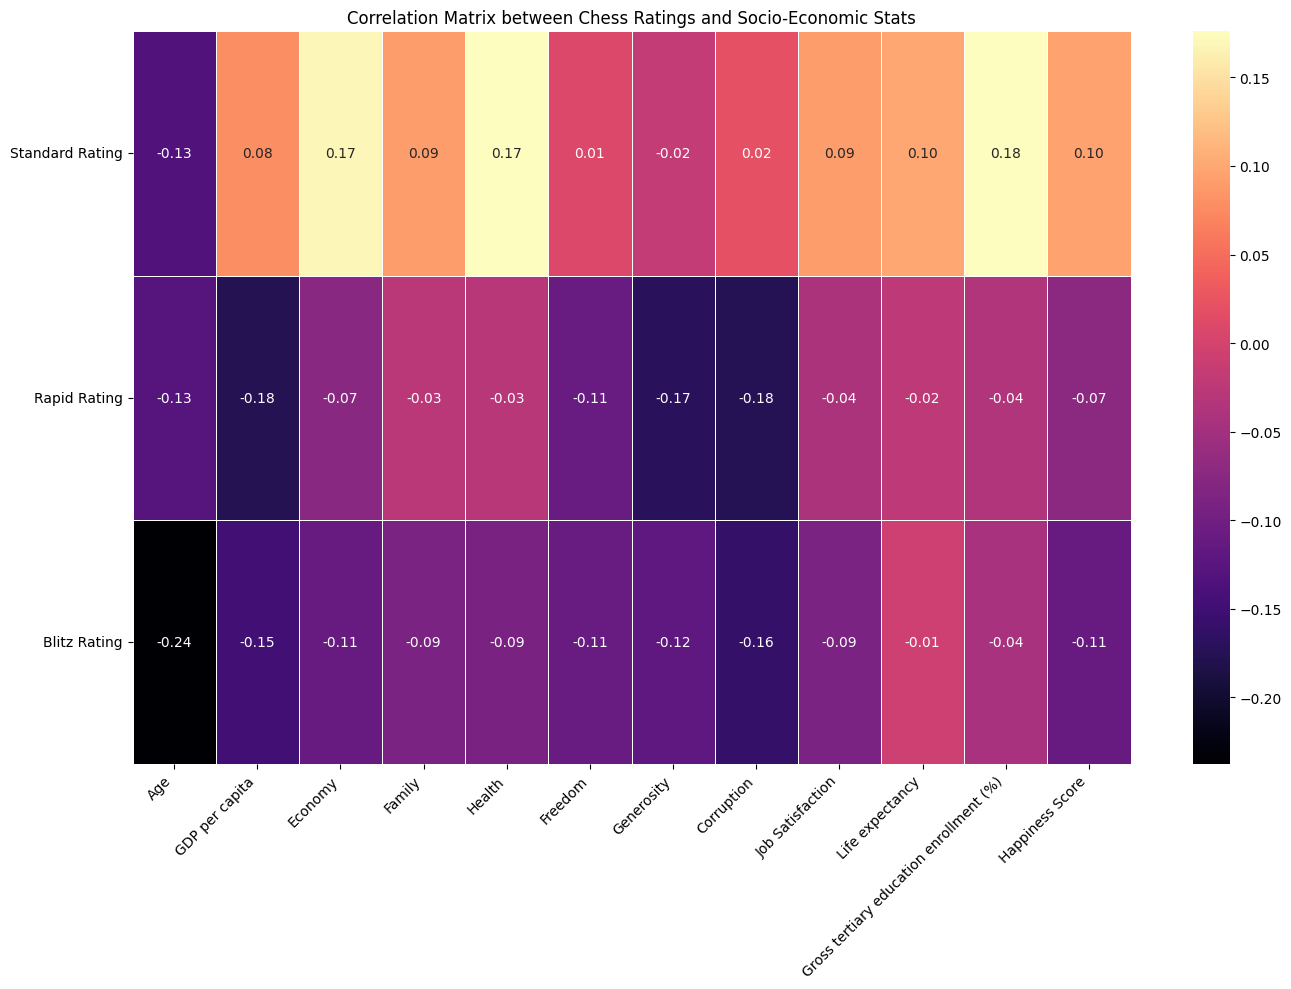

In [51]:

y_columns = ['Standard Rating', 'Rapid Rating', 'Blitz Rating']
x_columns = ['Age', 'GDP per capita', 'Economy', 'Family', 'Health',
             'Freedom', 'Generosity', 'Corruption', 'Job Satisfaction',
             'Life expectancy', 'Gross tertiary education enrollment (%)', 'Happiness Score']

heatmap_data = merged_data[y_columns + x_columns]

#normalizuj
scaler = MinMaxScaler()
heatmap_data_scaled = pd.DataFrame(scaler.fit_transform(heatmap_data), columns=heatmap_data.columns)

correlation_matrix = heatmap_data_scaled.corr()


plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(correlation_matrix.loc[y_columns, x_columns], annot=True, cmap='magma', fmt=".2f", linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)
plt.title('Correlation Matrix between Chess Ratings and Socio-Economic Stats')
plt.tight_layout()
plt.show()


Overall, the correlations are relatively weak, suggesting that while there are some relationships between socio-economic factors and chess ratings, they are not very strong. <br>
It's important to note that while GDP per capita, Population, and Gross Tertiary Education Enrollment can be precisely quantified, indicators such as 'Economy', 'Family', 'Freedom', 'Health', 'Generosity', and 'Corruption' are based on individuals' perceptions and self-reported experiences in these areas.

## Visualization of Titled Chess Players Distribution

<br>This code segment generates a bar plot that visualizes the distribution of titled chess players (Grandmasters, International Masters, and Candidate Masters) across the top 30 countries. Initially, the data is sorted in descending order based on the total number of titled players per country. The top 30 countries are then selected for the plot.

<Figure size 2500x1000 with 0 Axes>

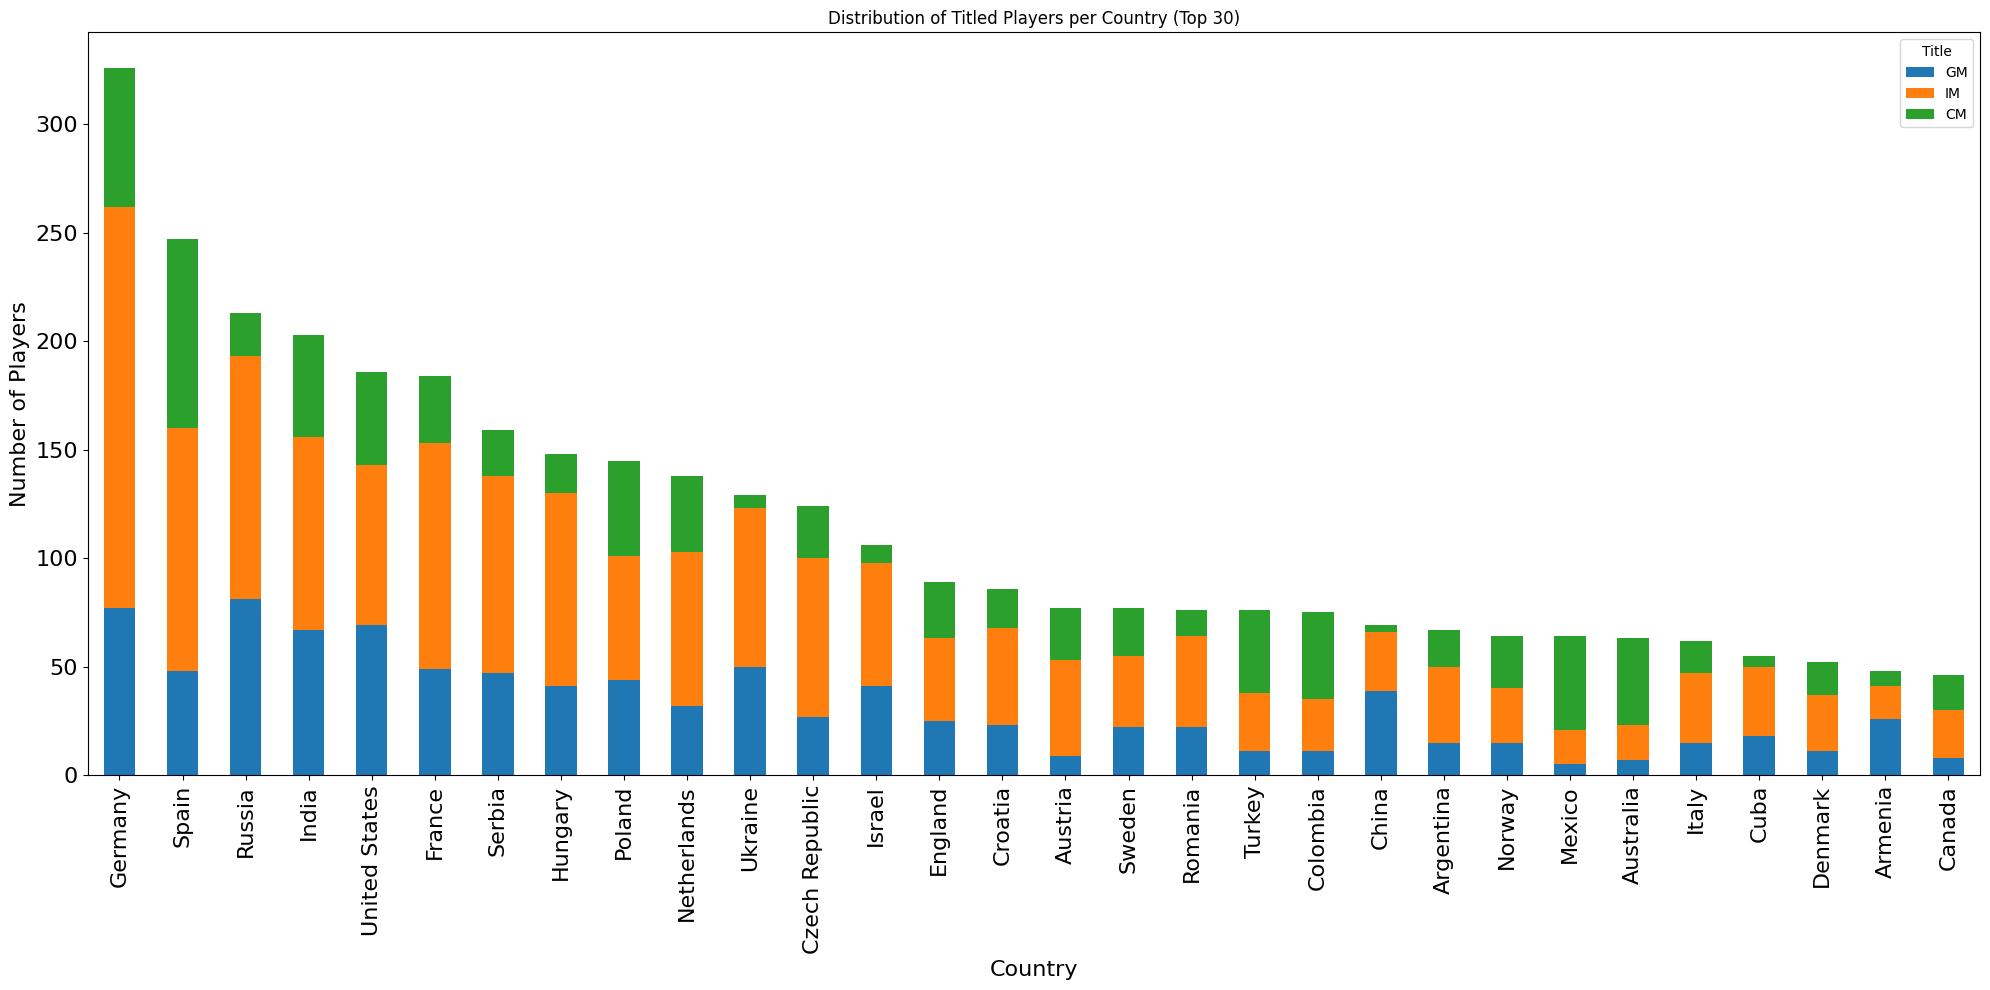

In [52]:
plt.figure(figsize=(25, 10))
titled_players = titled_players.sort_values(by='Total', ascending=False)
top_30_titled_players = titled_players.sort_values(by='Total', ascending=False).head(30)

top_30_titled_players[['GM', 'IM', 'CM']].plot(kind='bar', stacked=True, figsize=(20, 10))


plt.title('Distribution of Titled Players per Country (Top 30)')
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Players', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Title')
plt.tight_layout()
plt.show()


## Analysis of Titled Players per Capita and Socio-Economic Factors
This section of the code analyzes the relationship between the number of titled chess players per capita and various socio-economic factors. The data is first processed to calculate the number of Grandmasters, International Masters, and Candidate Masters per 100,000 people for each country. Any infinite or missing values are appropriately handled.<br>
The relevant columns are then selected to form the dataset for analysis, and the data is normalized using MinMaxScaler to ensure consistent scaling. A correlation matrix is computed to quantify the relationships between the number of titled players per capita and the socio-economic factors.

                    Age  GDP per capita   Economy    Family    Health  \
GM_per_capita  0.102726        0.091725  0.050123  0.004343  0.112218   
IM_per_capita  0.184467        0.099031  0.128275  0.045872  0.186604   
CM_per_capita  0.134874        0.214331  0.203735  0.154884  0.249380   

                Freedom  Generosity  Corruption  Job Satisfaction  \
GM_per_capita -0.177543    0.034030   -0.085752         -0.089131   
IM_per_capita -0.241418    0.018473   -0.097936         -0.021412   
CM_per_capita  0.051087    0.194688    0.075152          0.164378   

               Life expectancy  Gross tertiary education enrollment (%)  \
GM_per_capita         0.117856                                 0.098563   
IM_per_capita         0.179532                                 0.155396   
CM_per_capita         0.214849                                 0.199577   

               Happiness Score  
GM_per_capita         0.005615  
IM_per_capita         0.055864  
CM_per_capita         0.189598

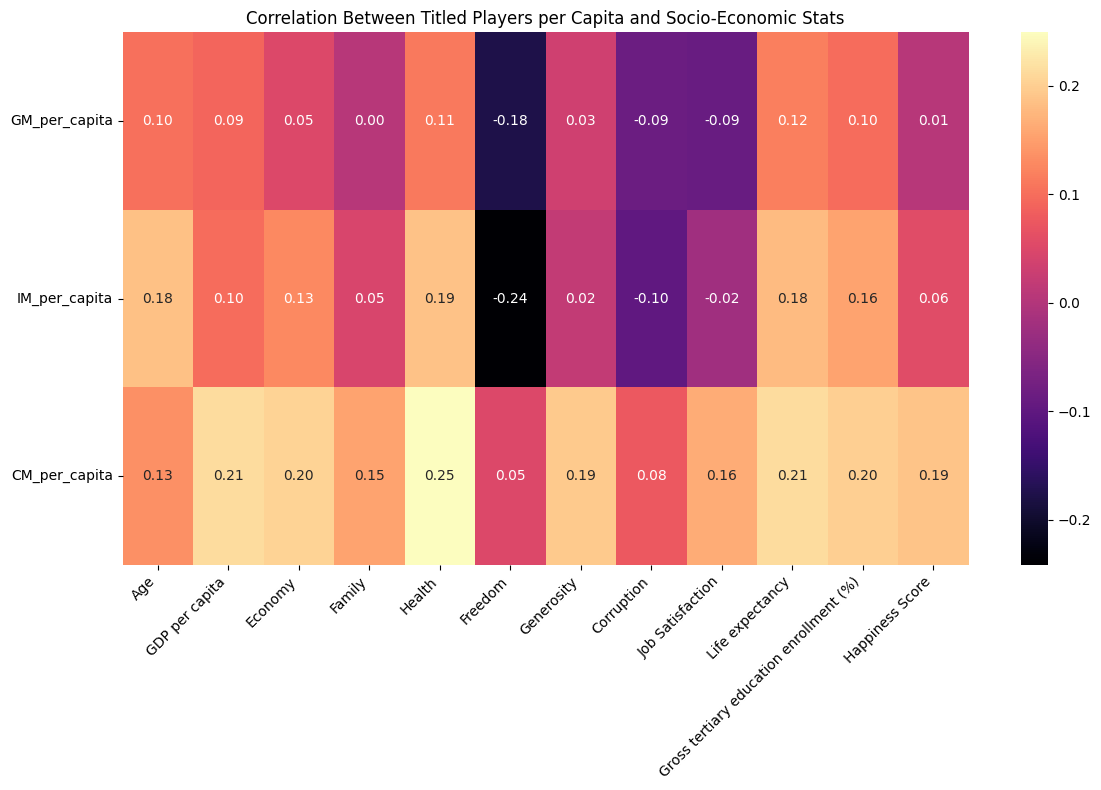

In [53]:
merged_data['GM_per_capita'] = merged_data['GM'] / (merged_data['Population'] / 100000)
merged_data['IM_per_capita'] = merged_data['IM'] / (merged_data['Population'] / 100000)
merged_data['CM_per_capita'] = merged_data['CM'] / (merged_data['Population'] / 100000)

merged_data['GM_per_capita'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
merged_data['IM_per_capita'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
merged_data['CM_per_capita'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
merged_data.fillna(0, inplace=True)
# removed some player playing under the FIDE flag
merged_data = merged_data[merged_data['Happiness Score'] != 0]

y_columns = ['GM_per_capita', 'IM_per_capita', 'CM_per_capita']
x_columns = ['Age', 'GDP per capita', 'Economy', 'Family', 'Health',
             'Freedom', 'Generosity', 'Corruption', 'Job Satisfaction',
             'Life expectancy', 'Gross tertiary education enrollment (%)', 'Happiness Score']

heatmap_data = merged_data[y_columns + x_columns]

scaler = MinMaxScaler()
heatmap_data_scaled = pd.DataFrame(scaler.fit_transform(heatmap_data), columns=heatmap_data.columns)

correlation_matrix = heatmap_data_scaled.corr()

correlation_with_titles = correlation_matrix.loc[y_columns, x_columns]
print(correlation_with_titles)

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_with_titles, annot=True, cmap='magma', fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)
plt.title('Correlation Between Titled Players per Capita and Socio-Economic Stats')
plt.tight_layout()
plt.show()


While most correlations are relatively weak, the analysis indicates that socio-economic factors such as health, wealth, and social support positively influence the development of titled chess players. Negative factors like corruption can hinder the growth of chess talent. These insights provide a nuanced understanding of how different socio-economic conditions impact chess performance across different levels of proficiency.

## Could chess players ever be truly happy? <br>

In this section, we visualize the relationship between chess player ratings (Standard, Rapid, Blitz) and the Happiness Score for various countries. The analysis is conducted through scatter plots and correlation calculations to understand the potential impact of happiness on chess performance. <br>

The relevant columns, including Standard Rating, Rapid Rating, Blitz Rating, and Happiness Score, are extracted from the merged dataset. These columns are then scaled using MinMaxScaler to ensure consistency in the analysis. Scatter plots are created to depict the relationship between Happiness Score and each type of chess rating. The plots exclude players without ratings in certain category to provide a more accurate representation.

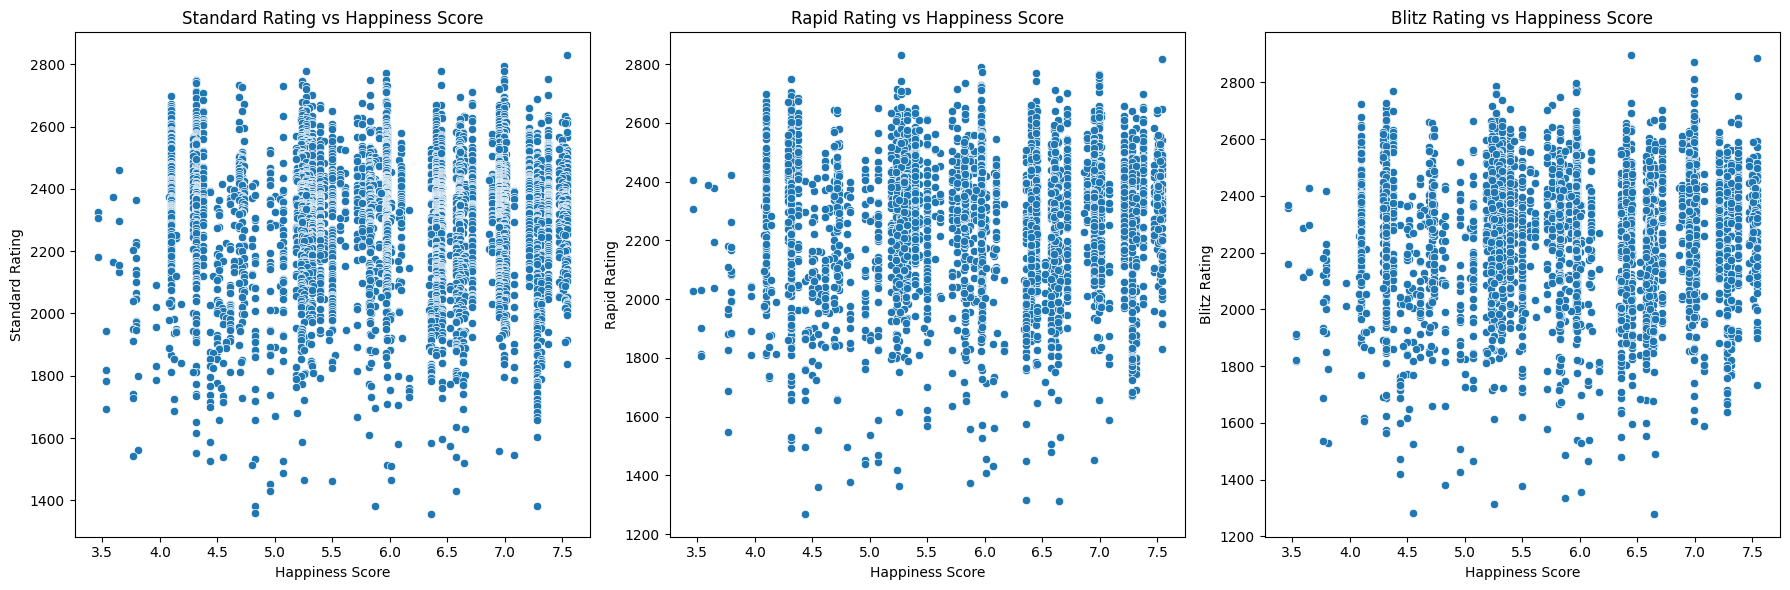

Correlation between Standard Rating and Happiness Score: 0.047184686300538285
Correlation between Rapid Rating and Happiness Score: -0.17091424272612737
Correlation between Blitz Rating and Happiness Score: -0.1588783100357446


In [54]:
columns = ['Standard Rating', 'Rapid Rating', 'Blitz Rating', 'Happiness Score']
data = merged_data[columns]

scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x=data['Happiness Score'], y=data['Standard Rating'])
plt.title('Standard Rating vs Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Standard Rating')


rapid_data = merged_data[merged_data['Rapid Rating'] != 0][columns]
plt.subplot(1, 3, 2)
sns.scatterplot(x=rapid_data['Happiness Score'], y=rapid_data['Rapid Rating'])
plt.title('Rapid Rating vs Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Rapid Rating')


blitz_data = merged_data[merged_data['Blitz Rating'] != 0][columns]
plt.subplot(1, 3, 3)
sns.scatterplot(x=blitz_data['Happiness Score'], y=blitz_data['Blitz Rating'])
plt.title('Blitz Rating vs Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Blitz Rating')

plt.tight_layout()
plt.show()

correlation_standard = data[['Standard Rating', 'Happiness Score']].corr().iloc[0, 1]
correlation_rapid = data[['Rapid Rating', 'Happiness Score']].corr().iloc[0, 1]
correlation_blitz = data[['Blitz Rating', 'Happiness Score']].corr().iloc[0, 1]

print("Correlation between Standard Rating and Happiness Score:", correlation_standard)
print("Correlation between Rapid Rating and Happiness Score:", correlation_rapid)
print("Correlation between Blitz Rating and Happiness Score:", correlation_blitz)


**Što južnije, to tužnije**

In [60]:
sample_players = merged_data[['Name', 'Country', 'Standard Rating', 'Rapid Rating', 'Blitz Rating', 'Happiness Score']].sample(5)
print(sample_players)

                     Name      Country  Standard Rating  Rapid Rating  \
2653  De Rover, Yong Hoon  Netherlands             2325           0.0   
3867         Nayak Rajesh        India             2170        2083.0   
3109     Benedetti, Julio    Argentina             2252        2232.0   
1168         Stopa, Jacek       Poland             2351        2511.0   
3815         Le, Tri Kien      Vietnam             2185        1894.0   

      Blitz Rating  Happiness Score  
2653        2365.0            7.377  
3867        2083.0            4.315  
3109        2284.0            6.599  
1168        2386.0            5.973  
3815        2010.0            5.074  


C:\Users\david\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


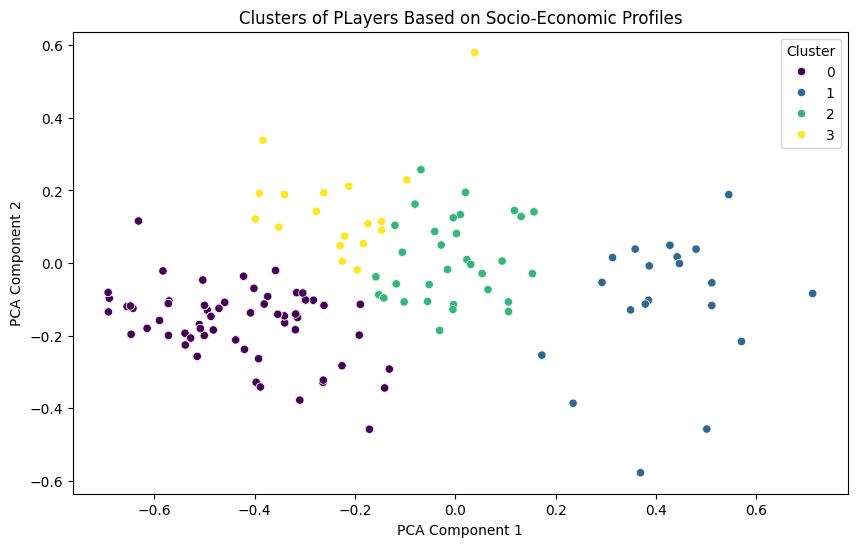

Cluster Centroids:
          GDP per capita  Gross tertiary education enrollment (%)  \
Cluster                                                            
0           2896.833743                                21.625576   
1          62296.863677                                77.052937   
2          17576.036296                                69.467901   
3          11342.492638                                68.061730   

         Happiness Score  
Cluster                   
0               5.065243  
1               7.157927  
2               6.240243  
3               4.991303  

Count of Players in Each Cluster:
 Cluster
2    1620
1    1311
3     925
0     911
Name: count, dtype: int64
Chess Ratings by Cluster:
         Standard Rating             Rapid Rating              Blitz Rating  \
                   mean         std         mean          std         mean   
Cluster                                                                      
0           2221.609221  252.345200  2

In [64]:
socio_economic_features = ['GDP per capita', 'Gross tertiary education enrollment (%)', 'Happiness Score']
socio_economic_data = merged_data[socio_economic_features]

scaler = MinMaxScaler()
socio_economic_data_scaled = pd.DataFrame(scaler.fit_transform(socio_economic_data), columns=socio_economic_data.columns)

kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(socio_economic_data_scaled)
merged_data['Cluster'] = clusters

pca = PCA(n_components=2)
pca_components = pca.fit_transform(socio_economic_data_scaled)
merged_data['PCA1'] = pca_components[:, 0]
merged_data['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=merged_data, palette='viridis')
plt.title('Clusters of PLayers Based on Socio-Economic Profiles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

cluster_centroids = merged_data.groupby('Cluster')[socio_economic_features].mean()
print("Cluster Centroids:\n", cluster_centroids)

cluster_counts = merged_data['Cluster'].value_counts()
print("\nCount of Players in Each Cluster:\n", cluster_counts)

cluster_ratings = merged_data.groupby('Cluster').agg({
    'Standard Rating': ['mean', 'std'],
    'Rapid Rating': ['mean', 'std'],
    'Blitz Rating': ['mean', 'std']
})

print("Chess Ratings by Cluster:\n", cluster_ratings)
